# 微分処理のテスト

## sift.pyをインポート

In [136]:
%cd ~/PycharmProjects/mps_20160220/noguchi

/Users/noguchi_osamu/PycharmProjects/mps_20160220/noguchi


In [137]:
%ls

__pycache__/ img/         sift.py


In [138]:
from PIL import Image
import numpy as np
from scipy.ndimage.filters import gaussian_filter
import matplotlib.pyplot as plt
from collections import OrderedDict

In [139]:
import sys
#del sys.modules['sift']
import sift
sys.modules['sift']

<module 'sift' from '/Users/noguchi_osamu/PycharmProjects/mps_20160220/noguchi/sift.py'>

## パラメータを設定

In [140]:
sigma=0.32
#sigma = 1.6
s= 3
k = np.power(2.0, 1.0/s)

## テスト用の条件を設定
### テスト用の関数を設定

In [141]:
def test(x):
    return np.sin(x)
    #return x ** 3

### テスト用の刻み幅を設定

In [142]:
def delta(i):
    #return sigma * np.power(k,i)
    return i * sigma

## テスト用のoctaveを作成 

In [143]:
octave = OrderedDict()
for i in range(1, s + 30):
        scale = delta(i)
        v = test(scale)
        octave[scale] = np.array([[v] * 3] * 3)

## プロットしてみる

In [144]:
%matplotlib inline

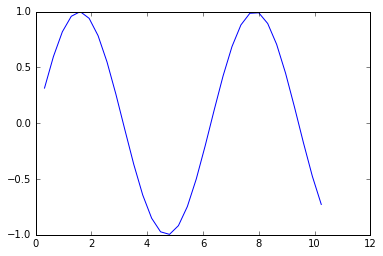

In [145]:
x = np.array([_x for _x in octave.keys()])
y = np.array([_y[0,0] for _y in octave.values()])
plt.plot(x,y)

## ダミーの変数を用いてExtremaSpaceを作成

In [146]:
dog_space = list(octave)

In [147]:
ex = sift.ExtremaSpace(dog_space)

## 微分(１階・２階)を実行

In [148]:
d2x = ex.d2fdx2(1, 1, x[1], x[1]-x[0], x[2]-x[1], octave)
d2x

array([[ 0.        ,  0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        ],
       [ 0.        ,  0.        , -0.59211674]])

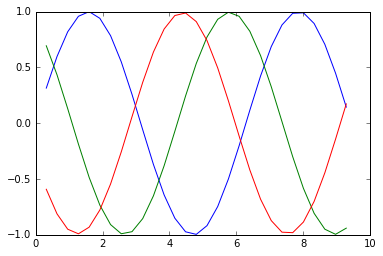

In [149]:
# １階微分
a = np.array([ex.dx(1, 1, x[i], x[i+1]-x[i], octave) for i in range(1,30)])
dy = np.array([_dy[2,0] for _dy in a])

# ２階微分
a = np.array([ex.d2fdx2(1, 1, x[i], x[i]-x[i-1], x[i+1]-x[i], octave) for i in range(1,30)])
dyy = np.array([_dy[2,2] for _dy in a])

plt.plot(x[0:29], y[0:29])
plt.plot(x[0:29], dy[0:29])
plt.plot(x[0:29], dyy[0:29])

## テイラー展開をしてみる
- テーラー展開式：
$$ f(x) = f(c) + \frac{df}{dx}\big|_c \cdot (x - c) + \frac{\partial^2 f}{\partial x^2}\big|_c \cdot (x-c)^2$$
- 極値の近似点（テーラー展開式上の極値）：
$$ \hat{x} = - \frac{\partial^2 f}{\partial x^2}^{-1} \cdot \frac{\partial f}{\partial x} \big|_c+ c$$
$$ f(\hat{x}) = f(c) - \frac{1}{2} \frac{\partial f}{\partial x}^T \frac{\partial^2 f}{\partial x^2}^{-1}\frac{\partial f}{\partial x}\big|_c $$ 

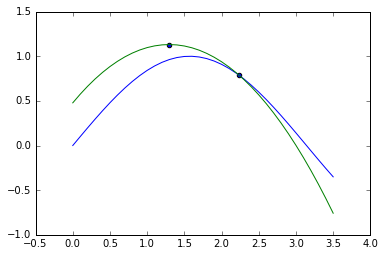

In [152]:
i = 6 # テーラー展開をする点
xmax = x[10] # グラフ表示の上限

# (1,1,c)でテーラー展開するために必要な係数を求める。
# ここでは、x, yは固定としているので、適当に1にしている。
# また、sigma = x[i], f(c)=y[i]です。

c = np.array([1,1,x[i]])[:, np.newaxis] # c
fc = y[i] # f(c)
dc = ex.dx(1, 1, x[i], x[i+1] - x[i], octave) # df/dx_c
dcc = ex.d2fdx2(1, 1, x[i], x[i]-x[i-1], x[i+1]-x[i], octave) # d2f/dx2_c

# Xを用意（一応、３次元ベクトルとして用意する）
x1 = np.array(np.arange(0, xmax, 0.1))
X = np.array([[[1], [1], [_x1]] for _x1 in x1])

# テーラー展開
Y1 = np.array([(fc + dc.T.dot(_X-c))[0,0] + 0.5 * ((_X-c).T.dot(dcc.dot(_X-c)))[0,0] for _X in X])

# x_hatを求める
#x_hat = np.linalg.inv(dcc).dot(dc) + c # 本当は逆行列が必要だが、正則でないので計算できない。
x_hat = -1.0 / dcc[2, 2] * dc[2] + c[2]
f_hat = fc - 0.5 * dc[2] * dc[2] / dcc[2,2]

# グラフをプロット
plt.plot(x1, test(x1)) # 元の関数
plt.plot(x1, Y1) # テーラー展開後の関数
plt.scatter(x[i], y[i]) # cをプロット
plt.scatter(x_hat, f_hat) # x_hat, f(x_hat)をプロット
